In [90]:
import os

from pyannote.core import Segment, Timeline, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

In [91]:
def txt2annotation(path_txt, annotation=Annotation()):
    with open(path_txt, 'r') as f:
        for line in f:
            if len(line) == 0:
                continue
            start, end, speaker = line.split()
            annotation[Segment(float(start), float(end))] = speaker
        return annotation


# Primero, una prueba sencilla

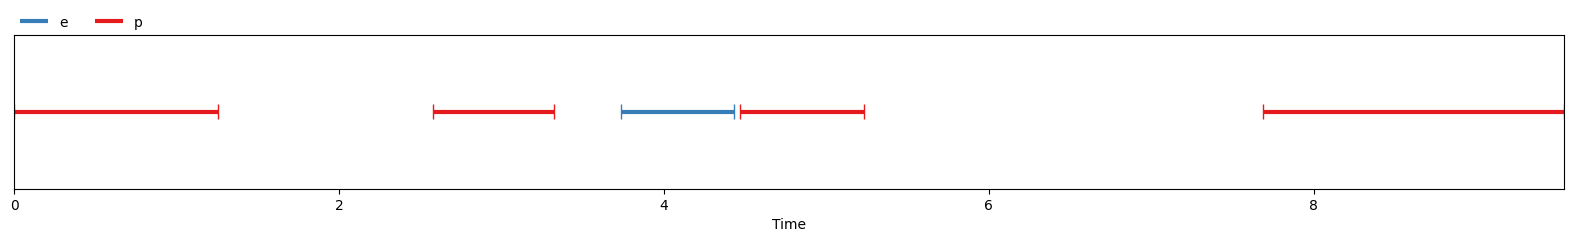

In [92]:
# reference annotation
reference_path = os.path.join('combined_database', 'reference', 'NP', 'CETRAM_AMG-0009_VocalSostenida.txt')
reference = txt2annotation(reference_path)
reference

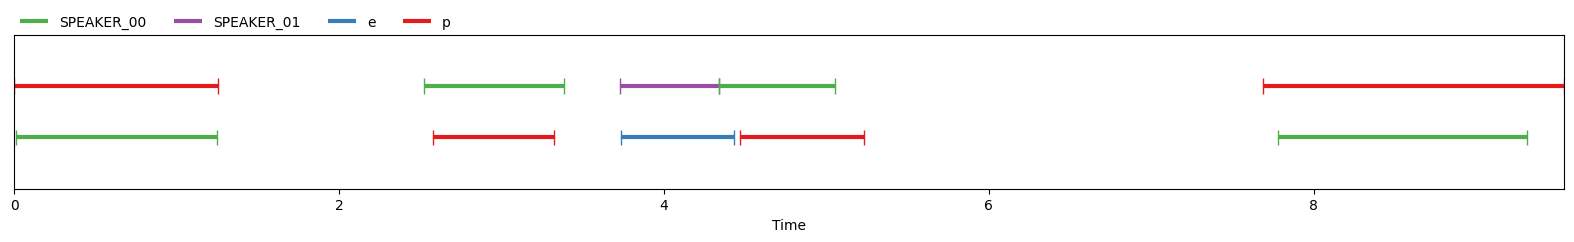

In [93]:
# hypothesis annotation
hypothesis_path = os.path.join('combined_database', 'hypothesis', 'NP', 'CETRAM_AMG-0009_VocalSostenida.txt')
hypothesis = txt2annotation(hypothesis_path)
hypothesis

In [94]:
# DER
metric(reference, hypothesis, detailed=True)

c:\Users\adolf\diariziation_error_rate\.env\Lib\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


{'confusion': 0.0,
 'total': 10.277330000000001,
 'correct': 10.277330000000001,
 'missed detection': 0.0,
 'false alarm': 0.0,
 'diarization error rate': 0.0}

In [95]:
# full report and reset metric
report = metric.report(display=True)
metric.reset()

      diarization error rate total correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                     %                       %                                 %                   %
item                                                                                                                            
None                    0.00 10.28   10.28  100.00        0.00        0.00             0.00             0.00      0.00      0.00
TOTAL                   0.00 10.28   10.28  100.00        0.00        0.00             0.00             0.00      0.00      0.00


# Ahora obtengamos un DER para todos los pares reference - hypothesis de la base combinada

In [96]:
# find all txt files in reference directory
reference_dir = os.path.join('combined_database', 'reference')
reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
# os walk to find all txt files in reference directory
count = 0
for root, dirs, files in os.walk(reference_dir):
    for file in files:
        if file.endswith('.txt'):
                reference_path = (os.path.join(root, file))
                annotation = Annotation(uri=file)
                reference = txt2annotation(reference_path, annotation)

                # find corresponding hypothesis file
                hypothesis_path = reference_path.replace('reference', 'hypothesis')
                annotation = Annotation(uri=file)
                hypothesis = txt2annotation(hypothesis_path, annotation)

                # compute DER
                metric(reference, hypothesis, detailed=True)

# cumulative report
print(abs(metric))
report = abs(metric.report(display=True))
report.to_csv('DER_report.csv')
metric.reset() # reset metric for next iteration

c:\Users\adolf\diariziation_error_rate\.env\Lib\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


0.3123337006752097
                                        diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                             %                       %                       %                                 %                   %
item                                                                                                                                                                
CETRAM_AMG-0009_VocalSostenida.txt                       12.76    5.33    4.74   88.85        0.09        1.61             0.46             8.65      0.13      2.50
CETRAM_AMG-0028_NarracionDeHistoria.txt                  25.05   30.69   27.62   89.97        4.61       15.02             3.03             9.86      0.05      0.16
CETRAM_AMG-0031_RecuerdoAgradable.txt                    17.36   40.37   34.73   86.02        1.37        3.39             3.86             9.57      1.78  